### Collecting data and processing data funcs:
Run this cell (select, then shift+enter)

In [1]:
#@title
from matplotlib import pyplot as plt
from pandas import json_normalize
import json
import pandas as pd
from tqdm import tqdm
import requests
import time
import seaborn as sns

sns.set_style("whitegrid")


def make_deep_requests(url, depth=5, limit=1000, sleep_time=2, stop_id=None):

    last_id = None
    data = pd.DataFrame()

    for counter in tqdm(range(depth)):
        if last_id:
            url += f'&lastId={last_id}'

        try:
            response = requests.get(url)
            new_data = json_normalize(json.loads(response.text))
            data = data.append(new_data)

        except Exception as exception:
            print(exception)
            import pdb; pdb.set_trace()

        last_id = data.id.iloc[-1]

        if len(new_data) < limit:
            break

        if stop_id in data['id'].values:
            break

        time.sleep(sleep_time)

    return data


def process_pool_data(df, token_decimals=6):

    convert = {
        'value.storage.tez_pool': lambda x: float(x) / 1_000_000,
        'value.storage.token_pool': lambda x: float(x) / (10**token_decimals),
        'timestamp': pd.Timestamp
    }

    for column_name, mapper in convert.items():
        df[column_name] = df[column_name].map(mapper)

    df['rate'] = df['value.storage.tez_pool'] / df['value.storage.token_pool']
    df = df.set_index('timestamp')
    return df


def collect_storage_history(smart_contract, depth=1):
    url = f'https://api.tzkt.io/v1/contracts/{smart_contract}/storage/history?limit=1000'
    return make_deep_requests(url, depth=depth)

### QuipuSwap contracts:
Insert here another QuipuSwap contracts if you want to

In [2]:
tokens = dict(
    hDAO = 'KT1QxLqukyfohPV5kPkw97Rs6cw1DDDvYgbB',      # 6 decimals
    WRAP = 'KT1FG63hhFtMEEEtmBSX2vuFmP87t9E7Ab4t',      # 8 decimals
    tCow = 'KT1XQZxsG4pMgcN7q7Nu3XFihsb9mEvqBmAT',      # 2 decimals
    bDAO = 'KT1DssMzoSr8fnUUq1WxeSuHfLG4gzS7pgge',      # 6 decimals
    sDAO = 'KT1WDe2vJCDqz5euKupppQsioPcakUd45Tfo',      # 0 decimals
    tCowLP = 'KT1UEfXGj5Ag73qCdZTk2534SZDT7cd7J8m8',    # ? decimals
    STKR = 'KT1BMEEPX7MWzwwadW3NCSZe9XGmFJ7rs7Dr',      # 18 decimals
    GUTS = 'KT1WYQj3HEt3sxdsV4dMLA8RKzUnYAzXgguS',      # 0 decimals
    Tacoz = 'KT1VfiExduEkrpM4TbsnAw9QV1VURqaRFGKs',     # 18 decimals
    token42 = 'KT1M5H8qkJEzhdC3ZxZ78bSxgmcddrcusbry',   # 0 decimals
    tSpanish = 'KT1A834QfnWremTQ4tc63s8NKbHzLJVszgxc',  # 0 decimals
    DeanCoin = 'KT1BAPAVXMuYz63HrF9CGM9Gu8JVYTFpYqao',  # 6 decimals
    tezos10x = 'KT1A4Sj8TBg4pazMkj226bAAcH6A4iCNQno4',  # 0? decimals
    RSAL = 'KT1PrRTVNgxkRgyqqNQvwTiVhd55dqyxXJ6n',      # 0 decimals
    banana = 'KT1Sd8jvepChHEHo63owNfjnqgzJEkUWSj9q',    # 2 decimals
    SHTz = 'KT1G7Z14RJLKbfu96Hc22bwNL67aykunAGyH',      # 2 decimals

    sUSD = 'KT1KFszq8UFCcWxnXuhZPUyHT9FK3gjmSKm6',      # 6 decimals
    ETHtz = 'KT1Evsp2yA19Whm24khvFPcwimK6UaAJu8Zo',     # 18 decimals
    kUSD = 'KT1K4EwTpbvYN9agJdjpyJm4ZZdhpUNKB3F6',      # 18 decimals

    wUSDC = 'KT1U2hs5eNdeCpHouAvQXGMzGFGJowbhjqmo',     # 6 decimals
    wWETH = 'KT1DuYujxrmgepwSDHtADthhKBje9BosUs1w',     # 18 decimals
    RITA = 'KT1L98jqwZtKUZbcPNxb3pTY7b2WXUGEzn8G',      # 6 decimals
    MEL = 'KT1BsDKTXBiYck85fJnoDzedyKKNtMuC9B9h',       # 6 decimals
    BDoge =  'KT1Th57AbgJmiZWDny6Ewqd2sx5qSxJwu8ry',    # 4 decimals
    wMATIC = 'KT1RsfuBee5o7GtYrdB7bzQ1M6oVgyBnxY4S',    # 18 decimals
)

### Requesting data:

In [3]:
# Select one contract from the above dictionary (just replace name in the quotes):
token = 'hDAO'
contract_address = tokens[token]

# Change token decimals if necessary (you could check comments in the dictionary in previous cell):
token_decimals = 6

# Set requests depth if there are needed more than one request to pull all data:
# (this can be useful to request data for tokens with long trading history)
requests_depth = 1

# Running requests & processing:
data = process_pool_data(
    collect_storage_history(contract_address, depth=requests_depth),
    token_decimals=token_decimals
)

100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


### Plot price dynamics:
You can change labels/names and colors if you would like

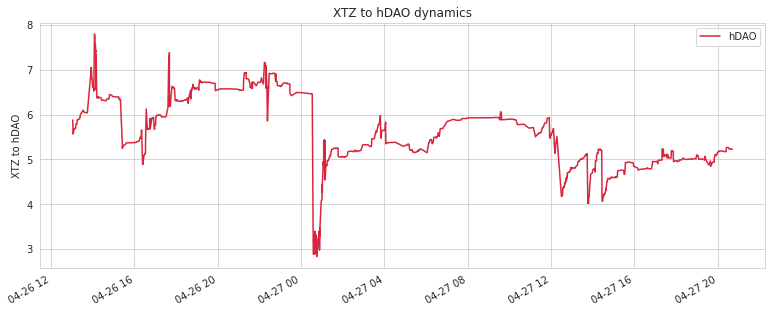

In [4]:
data.rate.rename(f'{token}').plot(color='#D7263D', figsize=(13,5))

plt.xlabel('')
plt.ylabel(f'XTZ to {token}')
plt.legend()
_ = plt.title(f'XTZ to {token} dynamics')

# If you want to save plot, uncomment this line:
# plt.savefig(f'{token}_price_dynamics.png')

### Plotting pools data:
This visualisation is about current liquidity in pools

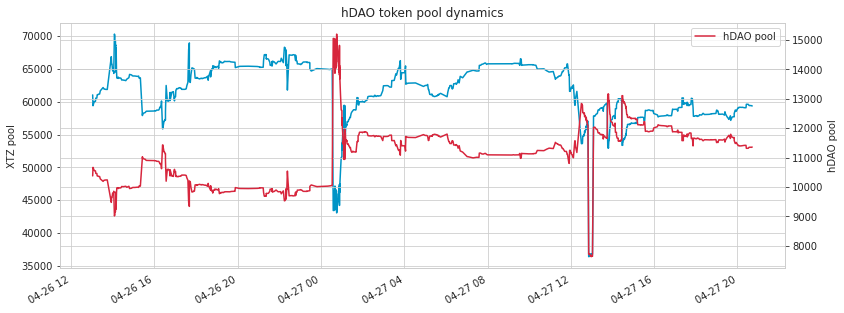

In [5]:
ax1 = data['value.storage.tez_pool'].rename(f'XTZ pool').plot(figsize=(13,5), color='#0094C6')
ax1.set_ylabel('XTZ pool')

ax2 = ax1.twinx()
ax2.set_ylabel(f'{token} pool')

data['value.storage.token_pool'].rename(f'{token} pool').plot(ax=ax2, color='#D7263D')

ax1.set_xlabel("")
plt.legend()
_ = plt.title(f'{token} token pool dynamics')

# If you want to save plot, uncomment this line:
# plt.savefig(f'{token}_pool_dynamics.png')

@ztepler